In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2024-06-14 02:29:47.650421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 02:29:47.650568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 02:29:47.904438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install split-folders
!pip install visualkeras
import visualkeras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 4.3 MB/s eta 0:00:0000:0100:01m


In [3]:
import splitfolders 
import visualkeras
splitfolders.ratio("/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice", 
                   output="padi-data", 
                   seed=42, 
                   ratio=(.8, .1, .1), 
                   group_prefix=None) 

Copying files: 4078 files [01:14, 54.56 files/s] 


In [4]:
training_dir = os.path.join('padi-data', 'train')
testing_dir = os.path.join('padi-data', 'test')
validating_dir = os.path.join('padi-data', 'val')

In [5]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 3261 images belonging to 4 classes.
Found 406 images belonging to 4 classes.
Found 411 images belonging to 4 classes.


In [6]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Rice___Brown_Spot': 0, 'Rice___Healthy': 1, 'Rice___Leaf_Blast': 2, 'Rice___Neck_Blast': 3}
['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']


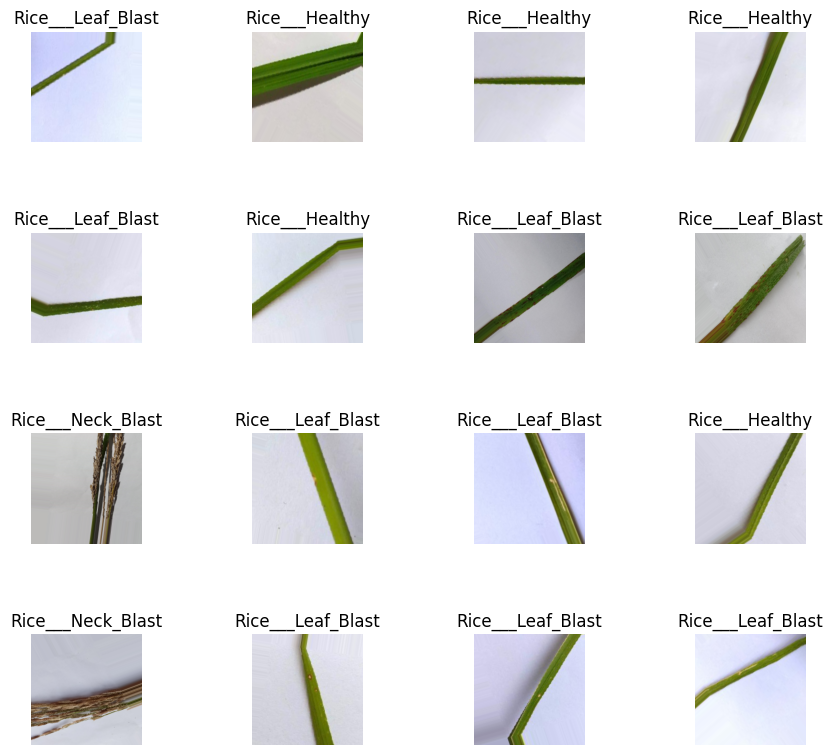

In [7]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None and acc > 0.88 and val_acc > 0.88:
            self.model.stop_training = True

In [35]:
tf.keras.backend.clear_session()

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

image_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNet(
    include_top=False,
    input_shape=image_shape,
    pooling=None,  # Remove the pooling parameter
    weights='imagenet',

)
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.3)(x)

output = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)
model.summary()



Number of layers in the base model:  86


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,282,564 (16.34 MB)

 Trainable params: 3,185,156 (12.15 MB)

 Non-trainable params: 1,097,408 (4.19 MB)

In [55]:
# rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
# checkpoint_path = 'model_checkpoint.h5'
# checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# # COMPILE MODEL HERE
# callbacks = myCallback()
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Definisi callback ReduceLROnPlateau
rlp = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

# Definisi callback ModelCheckpoint
checkpoint_path = 'model_checkpoint.keras'  # Ganti ekstensi menjadi .keras
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [59]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_epochs = 70

In [60]:
print("Validation data available:", len(validation_generator))
for batch in validation_generator:
    print("Validation batch shape:", batch[0].shape)
    break


Validation data available: 13
Validation batch shape: (32, 224, 224, 3)


In [61]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

training_history = model.fit(
    train_generator,
    epochs=total_epochs,
    verbose=1,
    callbacks=[rlp,checkpoint],
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    initial_epoch=0
)

Epoch 1/70
  2/101 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7500 - loss: 0.7105  

W0000 00:00:1718344282.470470     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.8372 - loss: 0.4699

W0000 00:00:1718344290.482480     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8989 - loss: 0.2947

W0000 00:00:1718344381.753325     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.95455
101/101 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8989 - loss: 0.2946 - val_accuracy: 0.6042 - val_loss: 1.8034 - learning_rate: 0.0010
Epoch 2/70
  1/101 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9688 - loss: 0.0797
Epoch 2: val_accuracy did not improve from 0.95455
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9688 - loss: 0.0797 - val_accuracy: 0.6818 - val_loss: 1.1788 - learning_rate: 0.0010
Epoch 3/70


W0000 00:00:1718344389.858120     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.8978 - loss: 0.2883
Epoch 3: val_accuracy did not improve from 0.95455
101/101 ━━━━━━━━━━━━━━━━━━━━ 107s 977ms/step - accuracy: 0.8978 - loss: 0.2884 - val_accuracy: 0.8880 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 4/70
  1/101 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7812 - loss: 0.6124
Epoch 4: val_accuracy did not improve from 0.95455
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.6124 - val_accuracy: 0.9545 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 5/70
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9069 - loss: 0.2617
Epoch 5: val_accuracy did not improve from 0.95455
101/101 ━━━━━━━━━━━━━━━━━━━━ 106s 985ms/step - accuracy: 0.9069 - loss: 0.2617 - val_accuracy: 0.8698 - val_loss: 0.3993 - learning_rate: 0.0010
Epoch 6/70
  1/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8750 - loss: 0.3214
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



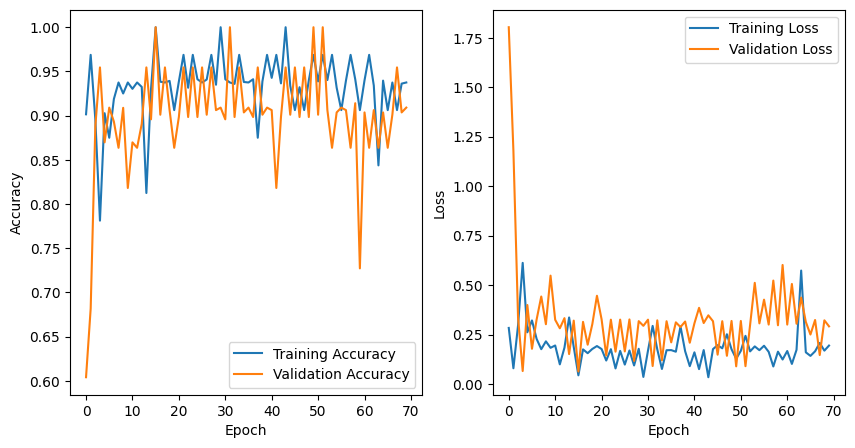

In [62]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [63]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 679ms/step - accuracy: 0.8921 - loss: 0.3464
Test loss: 0.35463467240333557 / Test accuracy: 0.8832116723060608


W0000 00:00:1718348138.695075     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [64]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Fungsi untuk memuat dan memproses gambar untuk prediksi
def load_and_process_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Preprocessing seperti yang dilakukan pada ImageDataGenerator
    return img_array

# Fungsi untuk melakukan prediksi menggunakan model
def predict_image(model, image_path, target_size=(224, 224)):
    img = load_and_process_image(image_path, target_size)
    prediction = model.predict(img)
    return prediction

# Contoh penggunaan
image_path = '/kaggle/input/agronify-dataset/DiseasedPlants/DiseasedPlants/Pertanian/Padi/Rice__brown_spot/DSC_0106.jpg' 
prediction = predict_image(model, image_path)

# Menampilkan hasil prediksi
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]

print("Predicted class:", predicted_class)
print("Prediction probabilities:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Rice___Brown_Spot
Prediction probabilities: [[9.8557276e-01 8.3839149e-09 1.4427212e-02 1.1681031e-09]]


In [65]:
model.save('rice_disease.h5')